In [2]:
import numpy as np
import fitsio
from astropy.table import Table, join
import os, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pandas as pd
import corner
import mpl_scatter_density

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

import sys
sys.path.insert(0, '/global/homes/s/severett/repos/balutils/')
from balutils import stacked_catalogs as sc

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)

/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [1]:
pwd

'/global/u2/s/severett/balrog-paper-plots'

In [3]:
stars_file = './cats/balrog_sof_gold_phot_delta_stars_sep.fits' 
df_stars_file = './cats/balrog_sof_gold_phot_df_stars_sep.fits' 

## Make Pure Star Sample

In [3]:
run = 'run2'
ver = '1.4'

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/stars/{}/sof/balrog_matched_catalog_sof_{}_stars_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/stars/{}/sof/balrog_detection_catalog_sof_{}_stars_v{}_avg_added_match_flags.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'meas_cm_mag_deredden', 'meas_gapflux', 'meas_cm_fracdev',
              'true_g_Corr', 'true_gr_corr', 'true_ri_Corr', 'true_iz_Corr', 'meas_cm_s2n_r', 'meas_cm_T']
det_cols = ['bal_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'meas_EXTENDED_CLASS_SOF','match_flag_1.5_asec']

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('joining...')
stars = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(stars)

cuts = np.where(
    (stars['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
    (stars['flags_foreground'] == 0 ) &
    (stars['flags_footprint'] == 1) &
    (stars['flags_badregions'] < 2) &
    (stars['match_flag_1.5_asec'] < 2)
)

print('Making cuts...')
stars = stars[cuts]

# Make mag cols for ease of use
stars['true_mag_g'] = stars['true_g_Corr']
stars['true_mag_r'] = stars['true_g_Corr'] - stars['true_gr_Corr']
stars['true_mag_i'] = stars['true_g_Corr'] - stars['true_gr_Corr'] - stars['true_ri_Corr']
stars['true_mag_z'] = stars['true_g_Corr'] - stars['true_gr_Corr'] - stars['true_ri_Corr'] - stars['true_iz_Corr']

Loading matched file...
Loading det file...
joining...
Making cuts...


In [4]:
print('Writing catalog...')
stars.write(stars_file, overwrite=True)

Writing catalog...


## Make DF Star Sample

In [14]:
run = 'y3-merged'
ver = '1.2'

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_matched_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_detection_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'meas_cm_mag_deredden',  'true_bdf_mag_deredden', 'true_gap_flux_fwhm4asec', 'meas_gapflux',
              'meas_cm_fracdev', 'true_bdf_fracdev']
det_cols = ['bal_id', 'true_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'match_flag_1.5_asec',
            'meas_EXTENDED_CLASS_SOF']
# sof = sc.BalrogMatchedCatalog(match_file, det_file, match_cols=match_cols, match_type='sof_only', vb=True)

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('Joining...')
sof = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(sof)

# Match to Ian's DF classifier
df_file = 'cats/ugriz-mof02-JHK-extcorr_27May20_kNN_class.fits'
df = Table.read(df_file)
df.rename_column('id', 'true_id')

print('Joining with df classifier...')
sof = join(sof, df, keys='true_id', join_type='left')

cuts = np.where(
    (sof['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
    (sof['flags_foreground'] == 0 ) &
    (sof['flags_footprint'] == 1) &
    (sof['flags_badregions'] < 2) &
#     (sof['NearestNeighbors_class'] == 2)
    (sof['match_flag_1.5_asec'] < 2) &
    (sof['NearestNeighbors_class'] >= 1) &
    (sof['NearestNeighbors_class'] <= 2)
)

print('Making cuts...')
sof = sof[cuts]

Loading matched file...
Loading det file...
Joining...
Joining with df classifier...


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)


Making cuts...


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([6591932.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  626675.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

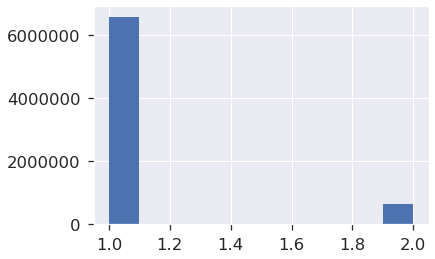

In [6]:
plt.hist(sof['NearestNeighbors_class'])

In [149]:
sof

true_bdf_fracdev,true_bdf_mag_deredden [4],true_gap_flux_fwhm4asec [4],bal_id,meas_gapflux [4],meas_cm_fracdev,meas_cm_mag_deredden [4],true_id,flags_footprint,flags_foreground,flags_badregions,meas_FLAGS_GOLD_SOF_ONLY,meas_EXTENDED_CLASS_SOF,match_flag_1.5_asec,NearestNeighbors_class
float64,float32,float64,int64,float64,float32,float64,int64,float64,float64,float64,int32,int64,int32,float64
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100143007070,72.26054385119306 .. 743.6106575647544,0.016359376,25.262830134820796 .. 22.784419183646715,691667161,1.0,0.0,0.0,0,2,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,102143060390,58.780756659269585 .. 674.5121194202567,0.0,25.45459325632351 .. 22.881606794210235,691667161,1.0,0.0,0.0,0,0,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100530030400,92.87377700316551 .. 574.0775920314607,0.0,25.01809336910934 .. 23.077799650080767,691667161,1.0,0.0,0.0,0,1,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100033025410,73.96187044077224 .. 577.0191004821912,0.0,25.278761470848284 .. 23.07870571187179,691667161,1.0,0.0,0.0,0,1,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100227022060,84.37814435587583 .. 672.73151677103,0.0,25.084180831700987 .. 22.875851323520457,691667161,1.0,0.0,0.0,0,3,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100521042490,83.11046257673735 .. 860.1533104151158,0.0,25.123950784938668 .. 22.633150372032752,691667161,1.0,0.0,0.0,0,1,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100221024580,131.76485320740198 .. 856.61425860241,0.0,24.642966615766035 .. 22.644402324554875,691667161,1.0,0.0,0.0,0,1,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,100101016240,52.96013224821596 .. 558.8356451035552,0.0,25.601261262880193 .. 23.08542366471427,691667161,1.0,0.0,0.0,0,3,0,2.0
0.49944168521427523,25.071697 .. 22.790302,90.9497263623678 .. 757.1813504596776,102242057480,64.88944114981437 .. 696.3565702395251,0.0,25.40844610261075 .. 22.869901991948396,691667161,1.0,0.0,0.0,0,0,0,2.0


In [15]:
print('Writing catalog...')
sof.write(df_stars_file, overwrite=True)

Writing catalog...


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([1.95074214e-07, 2.28001570e-08, 0.00000000e+00, 0.00000000e+00,
        4.83336134e-09, 1.28896971e-07, 8.57878940e-08, 1.84100290e-07,
        4.60443685e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.02405972e-07]),
 array([6.91667161e+08, 6.92744163e+08, 6.93821165e+08, 6.94898167e+08,
        6.95975169e+08, 6.97052172e+08, 6.98129174e+08, 6.99206176e+08,
        7.00283178e+08, 7.01360180e+08, 7.02437182e+08, 7.03514184e+08,
        7.04591186e+08, 7.05668188e+08, 7.06745190e+08, 7.07822192e+08,
        7.08899195e+08, 7.09976197e+08, 7.11053199e+08, 7.12130201e+08,
        7.13207203e+08]),
 <a list of 20 Patch objects>)

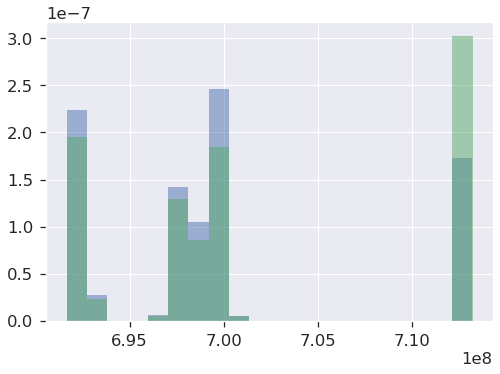

In [151]:
bins = 20
plt.hist(sof['true_id'], label='balrog', bins=bins, normed=True, alpha=0.5)
plt.hist(df['true_id'], label='df', bins=bins, normed=True, alpha=0.5)

In [152]:
df[df['true_id'] == 691667161]

NearestNeighbors_class,true_id
float64,int64
2.0,691667161


# Load Existing Catalogs

In [4]:
stars = Table.read(stars_file)
sof = Table.read(df_stars_file)

## Plots!

Text(0.5, 1.0, 'Balrog run2 pure stars (no match_flag yet)')

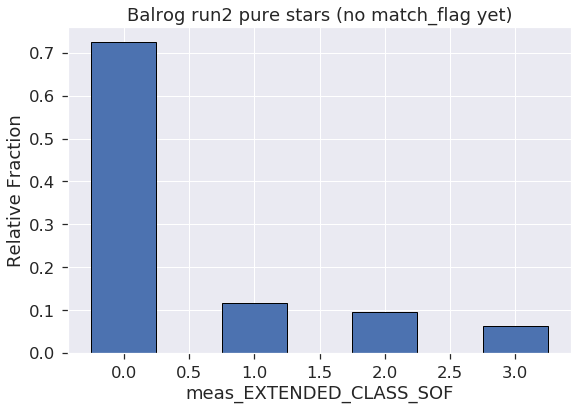

In [8]:
x = stars['meas_EXTENDED_CLASS_SOF']
weights = np.ones_like(x) / len(x)
db = 0.5
bins = np.arange(-db/2., 3+db, db)
plt.hist(x, ec='k', bins=bins, weights=weights)
plt.xlabel('meas_EXTENDED_CLASS_SOF')
plt.ylabel('Relative Fraction')
plt.gcf().set_size_inches(9,6)
plt.title('Balrog run2 pure stars (no match_flag yet)')

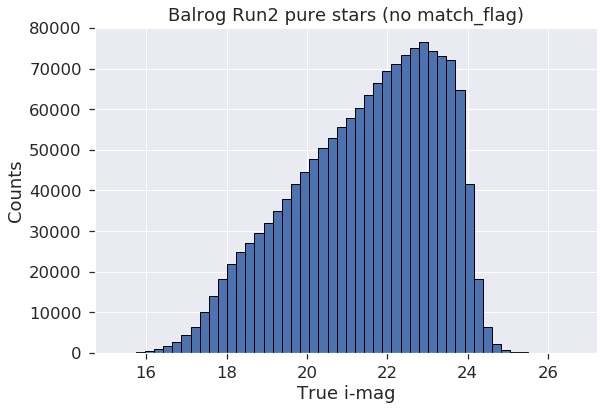

In [156]:
plt.hist(stars['true_mag_i'], bins=50, ec='k')
plt.xlabel('True i-mag')
plt.ylabel('Counts')
plt.title('Balrog Run2 pure stars (no match_flag)')
plt.gcf().set_size_inches(9,6)

## Star Contamination Plot

Starting i


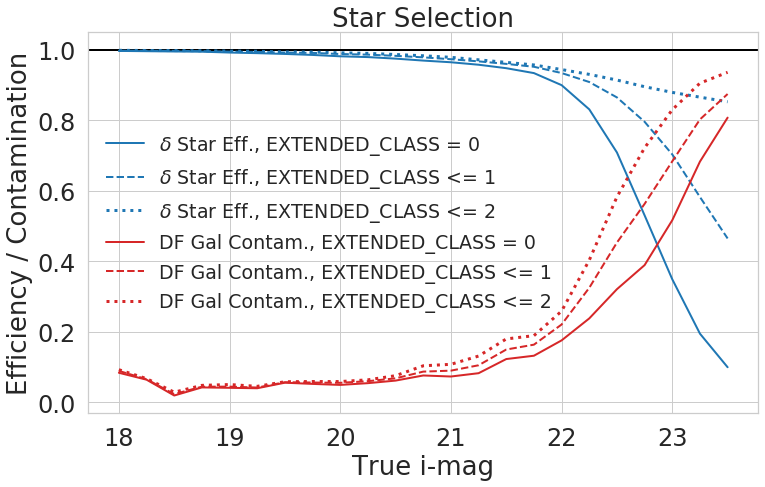

In [9]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 19
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bmin, bmax = 18, 23.75
db = 0.25
bins = np.arange(bmin, bmax, db)
Nbins = len(bins)

# band = 'i'
bindx = dict(zip('griz', range(4)))

col = 'meas_EXTENDED_CLASS_SOF'

knn = 'NearestNeighbors_class'
knn_gals = 1
knn_stars = 2 

for band in 'i':
    print(f'Starting {band}')
    bi = bindx[band]
    star_0 = np.zeros(Nbins)
    star_1 = np.zeros(Nbins)
    star_2 = np.zeros(Nbins)

    sof_0 = np.zeros(Nbins)
    sof_1 = np.zeros(Nbins)
    sof_2 = np.zeros(Nbins)
    
    star_mag = stars[f'true_mag_{band}']
    sof_mag = sof['true_bdf_mag_deredden'][:, bi]

    k = 0
    for b1, b2 in zip(bins, bins+db):
    #     print(b1, b2)
        if b1 >= bmax:
            break       

        star_in_bin = (star_mag >= b1) & (star_mag < b2)
        star_Nin_bin = len(np.where(star_in_bin == True)[0])

        star_ext0 = np.where(star_in_bin & (stars[col] == 0))
        star_ext1 = np.where(star_in_bin & (stars[col] <= 1))
        star_ext2 = np.where(star_in_bin & (stars[col] <= 2))

        sof_in_bin_gals = (sof_mag >= b1) & (sof_mag < b2) & (sof[knn]==knn_gals)
        sof_Nin_bin_gals = len(np.where(sof_in_bin_gals == True)[0])
        sof_in_bin_stars = (sof_mag >= b1) & (sof_mag < b2) & (sof[knn]==knn_stars)
        sof_Nin_bin_stars = len(np.where(sof_in_bin_stars == True)[0])

        sof_ext0_gals = np.where(sof_in_bin_gals & (sof[col] == 0))
        sof_ext1_gals = np.where(sof_in_bin_gals & (sof[col] <= 1))
        sof_ext2_gals = np.where(sof_in_bin_gals & (sof[col] <= 2))
        
        sof_ext0_stars = np.where(sof_in_bin_stars & (sof[col] == 0))
        sof_ext1_stars = np.where(sof_in_bin_stars & (sof[col] <= 1))
        sof_ext2_stars = np.where(sof_in_bin_stars & (sof[col] <= 2))

        try:
            # Stellar efficiency, or True Positive Rate (TP / TP+FN)
            star_0[k] = 1. * len(star_ext0[0]) / star_Nin_bin
            star_1[k] = 1. * len(star_ext1[0]) / star_Nin_bin
            star_2[k] = 1. * len(star_ext2[0]) / star_Nin_bin
        except ZeroDivisionError:
            star_0[k] = 0
            star_1[k] = 0
            star_2[k] = 0

        try:
            # The number of *measured* classified stars
#             sof_Nmeas_stars_in_bin = len(np.where((sof_mag >= b1) & (sof_mag < b2) & 
#                                                   (sof[col] >= 0) & (sof[col] <= 1))[0])
#             sof_Nmeas_stars_in_bin = sof_Nin_bin_stars

            

            # Galaxy Contamination, or False Discovery Rate (FP / FP+TP)
        
            
        
        
        
#             sof_0[k] = 1. * (len(sof_ext1_gals[0])+len(sof_ext2_gals[0])) / (len(sof_ext0_gals[0]) + len(sof_ext0_stars[0]))
            sof_0[k] = 1. * len(sof_ext0_gals[0]) / (len(sof_ext0_gals[0]) + len(sof_ext0_stars[0]))
            sof_1[k] = 1. * len(sof_ext1_gals[0]) / (len(sof_ext1_gals[0]) + len(sof_ext1_stars[0]))
            sof_2[k] = 1. * len(sof_ext2_gals[0]) / (len(sof_ext2_gals[0]) + len(sof_ext2_stars[0]))
#             sof_1[k] = 1. * len(sof_ext1_gals[0]) / sof_Nmeas_stars_in_bin
#             sof_2[k] = 1. * len(sof_ext2_gals[0]) / sof_Nmeas_stars_in_bin

#             sof_0[k] = 1. * len(sof_ext0_gals[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_1[k] = 1. * len(sof_ext1_gals[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_2[k] = 1. * len(sof_ext2_gals[0]) / (sof_Nin_bin + star_Nin_bin)
            
#             sof_0_stars[k] = 1. * len(sof_ext0[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_1_stars[k] = 1. * len(sof_ext1[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_2_stars[k] = 1. * len(sof_ext2[0]) / (sof_Nin_bin + star_Nin_bin) 
        except ZeroDivisionError:
            sof_0[k] = 0
            sof_1[k] = 0
            sof_2[k] = 0

        k += 1

    bmean = np.mean([bins, bins+db], axis=0)-db/2
    plt.axhline(1, lw=2, ls='-', c='k')
    plt.plot(bmean, star_0, lw=2, c='tab:blue', label=r'$\delta$ Star Eff., EXTENDED_CLASS = 0')
    plt.plot(bmean, star_1, lw=2, c='tab:blue', ls='--', label='$\delta$ Star Eff., EXTENDED_CLASS <= 1')
    plt.plot(bmean, star_2, lw=3, c='tab:blue', ls=':', label='$\delta$ Star Eff., EXTENDED_CLASS <= 2')
    plt.plot(bmean, sof_0, lw=2, c='tab:red', label='DF Gal Contam., EXTENDED_CLASS = 0')
    plt.plot(bmean, sof_1, lw=2, c='tab:red', ls='--', label='DF Gal Contam., EXTENDED_CLASS <= 1')
    plt.plot(bmean, sof_2, lw=3, c='tab:red', ls=':', label='DF Gal Contam., EXTENDED_CLASS <= 2')
    plt.legend(loc='best')
    plt.xlabel(f'True {band}-mag')
    plt.ylabel('Efficiency / Contamination')
    plt.title('Star Selection')
    plt.gcf().set_size_inches(12, 7)
    
plt.gcf().savefig('./figs/stellar_eff_cont.pdf', bbox_inches='tight')

Starting g


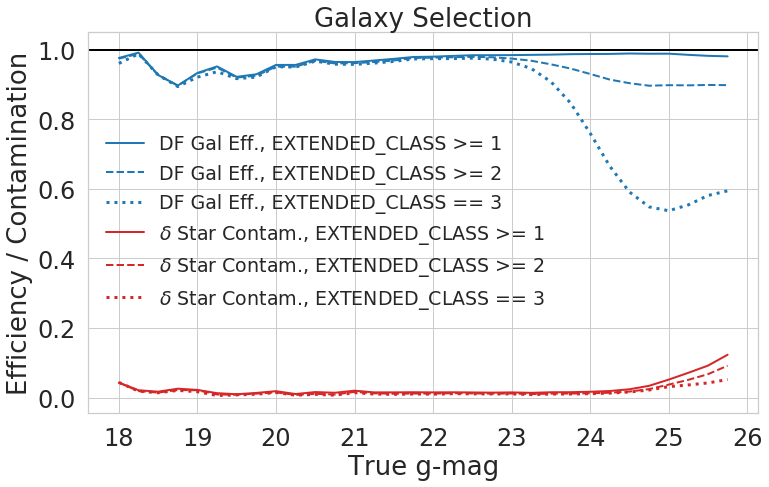

Starting r


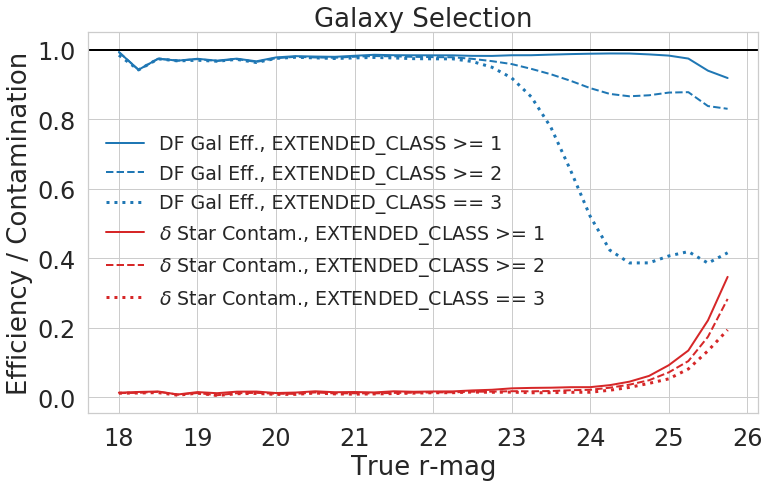

Starting i


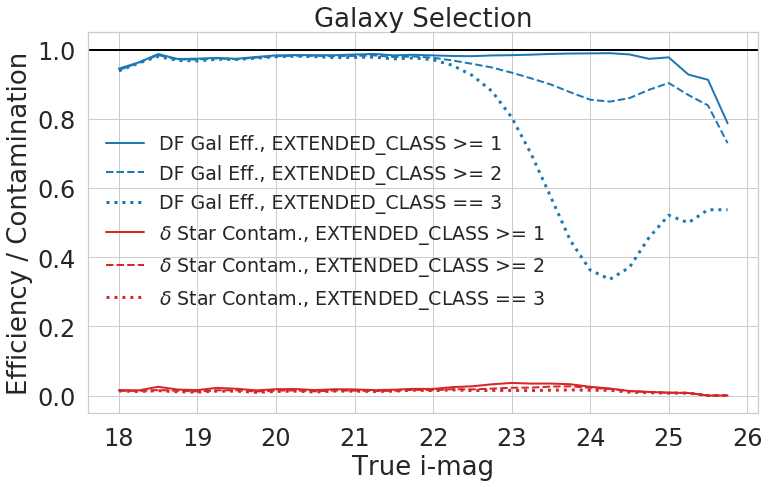

Starting z


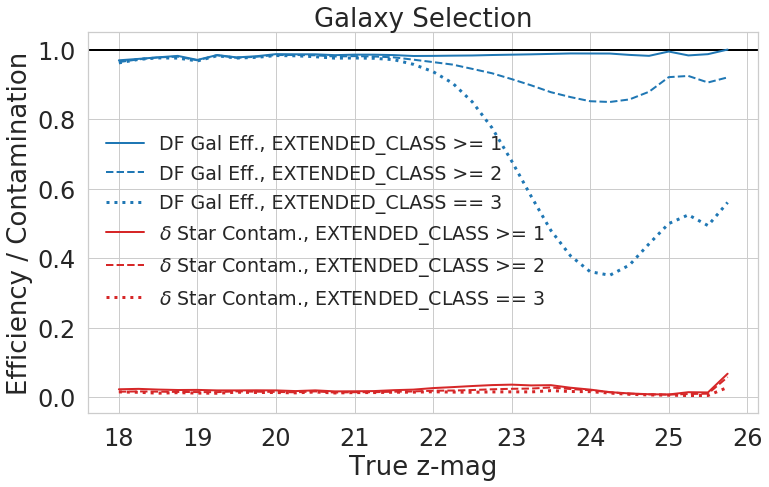

In [25]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bmin, bmax = 18, 26
db = 0.25
bins = np.arange(bmin, bmax, db)
Nbins = len(bins)

bindx = dict(zip('griz', range(4)))

col = 'meas_EXTENDED_CLASS_SOF'

knn = 'NearestNeighbors_class'
knn_gals = 1
knn_stars = 2 

for band in 'griz':
    print(f'Starting {band}')
    bi = bindx[band]
    
    # Efficiency
    eff_1 = np.zeros(Nbins)
    eff_2 = np.zeros(Nbins)
    eff_3 = np.zeros(Nbins)

    # Contamination
    con_1 = np.zeros(Nbins)
    con_2 = np.zeros(Nbins)
    con_3 = np.zeros(Nbins)
    
    star_mag = stars[f'true_mag_{band}']
    sof_mag = sof['true_bdf_mag_deredden'][:, bi]

    k = 0
    for b1, b2 in zip(bins, bins+db):
        if b1 >= bmax:
            break   

        star_in_bin = (star_mag >= b1) & (star_mag < b2)
        star_Nin_bin = len(np.where(star_in_bin == True)[0])

        star_ext1 = np.where(star_in_bin & (stars[col] >= 1))
        star_ext2 = np.where(star_in_bin & (stars[col] >= 2))
        star_ext3 = np.where(star_in_bin & (stars[col] == 3))

        sof_in_bin_gals = (sof_mag >= b1) & (sof_mag < b2) & (sof[knn]==knn_gals)
        sof_Nin_bin_gals = len(np.where(sof_in_bin_gals == True)[0])
        
        sof_in_bin_stars = (sof_mag >= b1) & (sof_mag < b2) & (sof[knn]==knn_stars)
        sof_Nin_bin_stars = len(np.where(sof_in_bin_stars == True)[0])

        sof_ext1_gals = np.where(sof_in_bin_gals & (sof[col] >= 1))
        sof_ext2_gals = np.where(sof_in_bin_gals & (sof[col] >= 2))
        sof_ext3_gals = np.where(sof_in_bin_gals & (sof[col] == 3))
        
        sof_ext1_stars = np.where(sof_in_bin_stars & (sof[col] >= 1))
        sof_ext2_stars = np.where(sof_in_bin_stars & (sof[col] >= 2))
        sof_ext3_stars = np.where(sof_in_bin_stars & (sof[col] == 3))

        try:
            # Galaxy efficiency, or True Positive Rate (TP / TP+FN)
            eff_1[k] = 1. * len(sof_ext1_gals[0]) / sof_Nin_bin_gals
            eff_2[k] = 1. * len(sof_ext2_gals[0]) / sof_Nin_bin_gals
            eff_3[k] = 1. * len(sof_ext3_gals[0]) / sof_Nin_bin_gals
        except ZeroDivisionError:
            eff_1[k] = 0
            eff_2[k] = 0
            eff_3[k] = 0

        try:
             # Stary Contamination, or False Discovery Rate (FP / FP+TP)
#             sof_0[k] = 1. * (len(sof_ext1_gals[0])+len(sof_ext2_gals[0])) / (len(sof_ext0_gals[0]) + len(sof_ext0_stars[0]))

            # Switching to trying DF...
            sof_in_bin = (sof_mag >= b1) & (sof_mag < b2)
            Npositive = len(sof[sof_in_bin & (sof[col])])
            
            con_1[k] = 1. * len(sof_ext1_stars[0]) / (len(sof_ext1_gals[0]) + len(sof_ext1_stars[0]))
            con_2[k] = 1. * len(sof_ext2_stars[0]) / (len(sof_ext2_gals[0]) + len(sof_ext2_stars[0]))
            con_3[k] = 1. * len(sof_ext3_stars[0]) / (len(sof_ext3_gals[0]) + len(sof_ext3_stars[0]))
#             con_1[k] = 1. * len(np.where(sof_in_bin_star & (sof[col] >= 1))) / len(sof[sof_in_bin & ])
#             con_2[k] = 1. * len(np.where(sof_in_bin_star & (sof[col] >= 2))) / star_Nin_bin
#             con_3[k] = 1. * len(np.where(sof_in_bin_star & (sof[col] == 3))) / star_Nin_bin

            # What I did before...
#             con_1[k] = 1. * len(np.where(star_in_bin & (stars[col] >= 1))) / star_Nin_bin
#             con_2[k] = 1. * len(np.where(star_in_bin & (stars[col] >= 2))) / star_Nin_bin
#             con_3[k] = 1. * len(np.where(star_in_bin & (stars[col] == 3))) / star_Nin_bin
            
#             con_2[k] = 1. * len(sof_ext1_stars[0]) / (len(sof_ext1_gals[0]) + len(sof_ext1_stars[0]))
#             con_3[k] = 1. * len(sof_ext2_stars[0]) / (len(sof_ext2_gals[0]) + len(sof_ext2_stars[0]))
#             sof_1[k] = 1. * len(sof_ext1_gals[0]) / sof_Nmeas_stars_in_bin
#             sof_2[k] = 1. * len(sof_ext2_gals[0]) / sof_Nmeas_stars_in_bin

#             sof_0[k] = 1. * len(sof_ext0_gals[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_1[k] = 1. * len(sof_ext1_gals[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_2[k] = 1. * len(sof_ext2_gals[0]) / (sof_Nin_bin + star_Nin_bin)
            
#             sof_0_stars[k] = 1. * len(sof_ext0[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_1_stars[k] = 1. * len(sof_ext1[0]) / (sof_Nin_bin + star_Nin_bin) 
#             sof_2_stars[k] = 1. * len(sof_ext2[0]) / (sof_Nin_bin + star_Nin_bin) 
        except ZeroDivisionError:
            con_0[k] = 0
            con_1[k] = 0
            con_2[k] = 0

        k += 1
        
#         break

    bmean = np.mean([bins, bins+db], axis=0) - db/2
#     bb = bins[:-1]
    plt.axhline(1, lw=2, ls='-', c='k')
    plt.plot(bmean, eff_1, lw=2, c='tab:blue', label=r'DF Gal Eff., EXTENDED_CLASS >= 1')
    plt.plot(bmean, eff_2, lw=2, c='tab:blue', ls='--', label='DF Gal Eff., EXTENDED_CLASS >= 2')
    plt.plot(bmean, eff_3, lw=3, c='tab:blue', ls=':', label='DF Gal Eff., EXTENDED_CLASS == 3')
    plt.plot(bmean, con_1, lw=2, c='tab:red', label=r'$\delta$ Star Contam., EXTENDED_CLASS >= 1')
    plt.plot(bmean, con_2, lw=2, c='tab:red', ls='--', label=r'$\delta$ Star Contam., EXTENDED_CLASS >= 2')
    plt.plot(bmean, con_3, lw=3, c='tab:red', ls=':', label=r'$\delta$ Star Contam., EXTENDED_CLASS == 3')
    plt.legend(loc='best')
    plt.xlabel(f'True {band}-mag')
    plt.ylabel('Efficiency / Contamination')
    plt.title('Galaxy Selection')
    plt.gcf().set_size_inches(12, 7)
    
    if band == 'i':
        plt.gcf().savefig('./figs/gals_eff_cont.pdf', bbox_inches='tight')
    plt.show()

Starting i
19.0
20.0
21.0
22.0
23.0
24.0


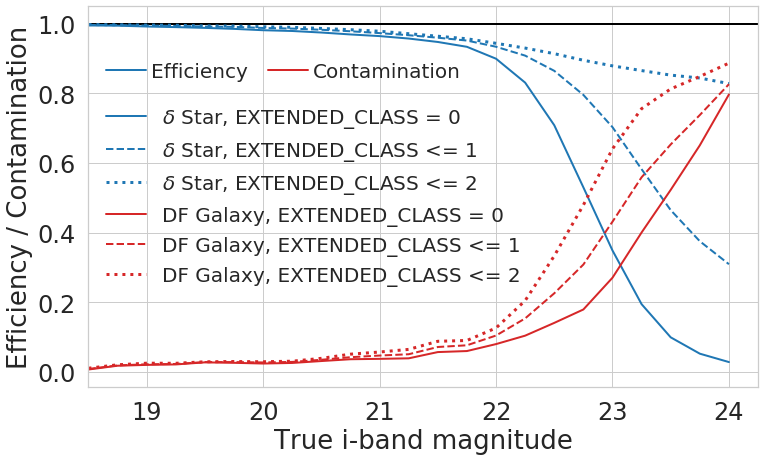

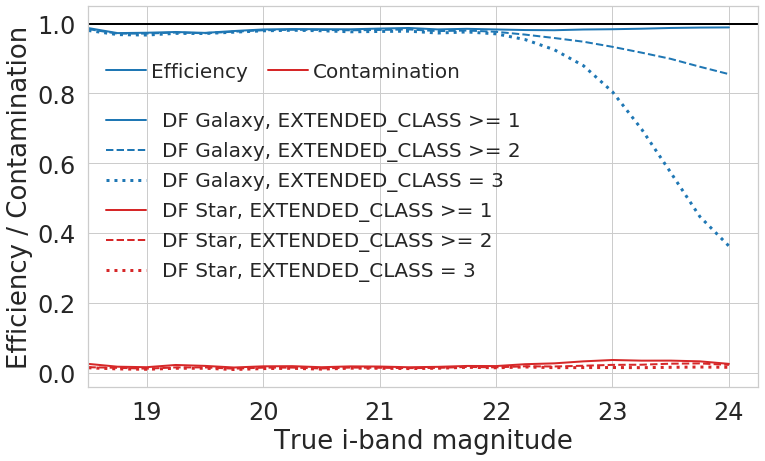

In [5]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bmin, bmax = 18.5, 24.25
db = 0.25
bins = np.arange(bmin, bmax, db)
Nbins = len(bins)

bindx = dict(zip('griz', range(4)))

ecol = 'meas_EXTENDED_CLASS_SOF'

knn = 'NearestNeighbors_class'
knn_gals = 1
knn_stars = 2 

for band in 'i':
    print(f'Starting {band}')
    bi = bindx[band]
    
    # DF Sample
    df_col = 'true_bdf_mag_deredden'
    # Delta Sample
    del_col = f'true_mag_{band}'
    
    # Efficiency
    star_eff_0 = np.zeros(Nbins)
    star_eff_1 = np.zeros(Nbins)
    star_eff_2 = np.zeros(Nbins)
    gal_eff_1 = np.zeros(Nbins)
    gal_eff_2 = np.zeros(Nbins)
    gal_eff_3 = np.zeros(Nbins)

    # Contamination
    star_cont_0 = np.zeros(Nbins)
    star_cont_1 = np.zeros(Nbins)
    star_cont_2 = np.zeros(Nbins)
    gal_cont_1 = np.zeros(Nbins)
    gal_cont_2 = np.zeros(Nbins)
    gal_cont_3 = np.zeros(Nbins)
    
#     star_mag = stars[f'true_mag_{band}']
#     sof_mag = sof['true_bdf_mag_deredden'][:, bi]

    k = 0
    for b1, b2 in zip(bins, bins+db):
        if b1 % 1 == 0:
            print(b1)
        if b1 >= bmax:
            break 
            
        ##############################################################################
        # Delta Sample
        del_in_bin = (stars[del_col] >= b1) & (stars[del_col] < b2)
        
        # Perfect classification knowledge
        del_true_stars_in_bin = del_in_bin
        
        del_leq_ext0_in_bin = del_in_bin & (stars[ecol] == 0)
        del_leq_ext1_in_bin = del_in_bin & (stars[ecol] >= 0) & (stars[ecol] <= 1)
        del_leq_ext2_in_bin = del_in_bin & (stars[ecol] >= 0) & (stars[ecol] <= 2)
        del_leq_ext3_in_bin = del_in_bin & (stars[ecol] >= 0) & (stars[ecol] <= 3)
        
        # Not currently needed...
#         del_geq_ext0_in_bin = del_in_bin & (stars[ecol] >= 0) & (stars[ecol] <= 3)
#         del_geq_ext1_in_bin = del_in_bin & (stars[ecol] >= 1) & (stars[ecol] <= 3)
#         del_geq_ext2_in_bin = del_in_bin & (stars[ecol] >= 2) & (stars[ecol] <= 3)
#         del_geq_ext3_in_bin = del_in_bin & (stars[ecol] == 3)
            
        ##############################################################################
        # DF Sample

        df_in_bin = (sof[df_col][:,bi] >= b1) & (sof[df_col][:,bi] < b2)

        df_true_stars_in_bin = df_in_bin & (sof[knn] == knn_stars)
        df_true_gals_in_bin = df_in_bin & (sof[knn] == knn_gals)

        df_leq_ext0_in_bin = df_in_bin & (sof[ecol] == 0)
        df_leq_ext1_in_bin = df_in_bin & (sof[ecol] >= 0) & (sof[ecol] <= 1)
        df_leq_ext2_in_bin = df_in_bin & (sof[ecol] >= 0) & (sof[ecol] <= 2)
        df_leq_ext3_in_bin = df_in_bin & (sof[ecol] >= 0) & (sof[ecol] <= 3)
        
        df_geq_ext0_in_bin = df_in_bin & (sof[ecol] >= 0) & (sof[ecol] <= 3)
        df_geq_ext1_in_bin = df_in_bin & (sof[ecol] >= 1) & (sof[ecol] <= 3)
        df_geq_ext2_in_bin = df_in_bin & (sof[ecol] >= 2) & (sof[ecol] <= 3)
        df_geq_ext3_in_bin = df_in_bin & (sof[ecol] == 3)
        
        ##############################################################################
        # For Stellar selection:
        
        # We use the delta sample for TP and FN, and DF sample for FP and TN
        
        stars_true_positive_0 = np.where(del_true_stars_in_bin & del_leq_ext0_in_bin)[0]
        stars_true_positive_1 = np.where(del_true_stars_in_bin & del_leq_ext1_in_bin)[0]
        stars_true_positive_2 = np.where(del_true_stars_in_bin & del_leq_ext2_in_bin)[0]

        # To use DF sample instead:
#         stars_true_positive_0 = np.where(df_true_stars_in_bin & df_leq_ext0_in_bin)[0]
#         stars_true_positive_1 = np.where(df_true_stars_in_bin & df_leq_ext1_in_bin)[0]
#         stars_true_positive_2 = np.where(df_true_stars_in_bin & df_leq_ext2_in_bin)[0]
#         stars_true_positive_3 = np.where(df_true_stars_in_bin & df_ext3_in_bin)[0]
        
        stars_false_positive_0 = np.where(df_true_gals_in_bin & df_leq_ext0_in_bin)[0]
        stars_false_positive_1 = np.where(df_true_gals_in_bin & df_leq_ext1_in_bin)[0]
        stars_false_positive_2 = np.where(df_true_gals_in_bin & df_leq_ext2_in_bin)[0]
#         stars_false_positive_3 = np.where(df_true_gals_in_bin & df_ext3_in_bin)[0]
        
        stars_false_negative_0 = np.where(del_true_stars_in_bin & ~del_leq_ext0_in_bin)[0]
        stars_false_negative_1 = np.where(del_true_stars_in_bin & ~del_leq_ext1_in_bin)[0]
        stars_false_negative_2 = np.where(del_true_stars_in_bin & ~del_leq_ext2_in_bin)[0]
        # Too use DF sample instead:
#         stars_false_negative_0 = np.where(df_true_stars_in_bin & ~df_leq_ext0_in_bin)[0]
#         stars_false_negative_1 = np.where(df_true_stars_in_bin & ~df_leq_ext1_in_bin)[0]
#         stars_false_negative_2 = np.where(df_true_stars_in_bin & ~df_leq_ext2_in_bin)[0]
#         stars_false_negative_3 = np.where(df_true_stars_in_bin & ~df_ext3_in_bin)[0]
        
        stars_true_negative_0 = np.where(df_true_gals_in_bin & ~df_leq_ext0_in_bin)[0]
        stars_true_negative_1 = np.where(df_true_gals_in_bin & ~df_leq_ext1_in_bin)[0]
        stars_true_negative_2 = np.where(df_true_gals_in_bin & ~df_leq_ext2_in_bin)[0]
#         stars_true_negative_3 = np.where(df_true_gals_in_bin & ~df_ext3_in_bin)[0]

        ##############################################################################
        # For Galaxy selection:
        
#         gals_true_positive_0 = np.where(df_true_gals_in_bin & df_ext0_in_bin)[0]
        gals_true_positive_1 = np.where(df_true_gals_in_bin & df_geq_ext1_in_bin)[0]
        gals_true_positive_2 = np.where(df_true_gals_in_bin & df_geq_ext2_in_bin)[0]
        gals_true_positive_3 = np.where(df_true_gals_in_bin & df_geq_ext3_in_bin)[0]
        
#         gals_false_positive_0 = np.where(df_true_gals_in_bin & df_ext0_in_bin)[0]
        gals_false_positive_1 = np.where(df_true_stars_in_bin & df_geq_ext1_in_bin)[0]
        gals_false_positive_2 = np.where(df_true_stars_in_bin & df_geq_ext2_in_bin)[0]
        gals_false_positive_3 = np.where(df_true_stars_in_bin & df_geq_ext3_in_bin)[0]
        
#         gals_false_negative_0 = np.where(df_true_gals_in_bin & ~df_ext0_in_bin)[0]
        gals_false_negative_1 = np.where(df_true_gals_in_bin & ~df_geq_ext1_in_bin)[0]
        gals_false_negative_2 = np.where(df_true_gals_in_bin & ~df_geq_ext2_in_bin)[0]
        gals_false_negative_3 = np.where(df_true_gals_in_bin & ~df_geq_ext3_in_bin)[0]
        
#         gals_true_negative_0 = np.where(df_true_gals_in_bin & ~df_ext0_in_bin)[0]
        gals_true_negative_1 = np.where(df_true_stars_in_bin & ~df_geq_ext1_in_bin)[0]
        gals_true_negative_2 = np.where(df_true_stars_in_bin & ~df_geq_ext2_in_bin)[0]
        gals_true_negative_3 = np.where(df_true_stars_in_bin & ~df_geq_ext3_in_bin)[0]


        # Efficiency is True Positive Rate (TPR): TP / P = TP / (TP + FN)
        try:
            star_eff_0[k] = len(stars_true_positive_0) / (len(stars_true_positive_0) + len(stars_false_negative_0))
            star_eff_1[k] = len(stars_true_positive_1) / (len(stars_true_positive_1) + len(stars_false_negative_1))
            star_eff_2[k] = len(stars_true_positive_2) / (len(stars_true_positive_2) + len(stars_false_negative_2))
            
            gal_eff_1[k]  = len(gals_true_positive_1) / (len(gals_true_positive_1) + len(gals_false_negative_1))
            gal_eff_2[k]  = len(gals_true_positive_2) / (len(gals_true_positive_2) + len(gals_false_negative_2))
            gal_eff_3[k]  = len(gals_true_positive_3) / (len(gals_true_positive_3) + len(gals_false_negative_3))
            
        except ZeroDivisionError:
            star_eff_0[k] = 0
            star_eff_1[k] = 0
            star_eff_2[k] = 0
            gal_eff_1[k] = 0
            gal_eff_2[k] = 0
            gal_eff_3[k] = 0

        # Contamination is False Discovery Rate (FDR): FP / (FP + TP)
        try:
            star_cont_0[k] = len(stars_false_positive_0) / (len(stars_false_positive_0) + len(stars_true_positive_0))
            star_cont_1[k] = len(stars_false_positive_1) / (len(stars_false_positive_1) + len(stars_true_positive_1))
            star_cont_2[k] = len(stars_false_positive_2) / (len(stars_false_positive_2) + len(stars_true_positive_2))
            
            gal_cont_1[k] = len(gals_false_positive_1) / (len(gals_false_positive_1) + len(gals_true_positive_1))
            gal_cont_2[k] = len(gals_false_positive_2) / (len(gals_false_positive_2) + len(gals_true_positive_2))
            gal_cont_3[k] = len(gals_false_positive_3) / (len(gals_false_positive_3) + len(gals_true_positive_3))
            
        except ZeroDivisionError:
            star_cont_0[k] = 0
            star_cont_1[k] = 0
            star_cont_2[k] = 0
            gal_cont_1[k] = 0
            gal_cont_2[k] = 0
            gal_cont_3[k] = 0
            
        k += 1
    
    bmean = np.mean([bins, bins+db], axis=0)-db/2
    plt.axhline(1, lw=2, ls='-', c='k')
    plt.plot(bmean, star_eff_0, lw=2, c='tab:blue', label=r'$\delta$ Star, EXTENDED_CLASS = 0')
    plt.plot(bmean, star_eff_1, lw=2, c='tab:blue', ls='--', label='$\delta$ Star, EXTENDED_CLASS <= 1')
    plt.plot(bmean, star_eff_2, lw=3, c='tab:blue', ls=':', label='$\delta$ Star, EXTENDED_CLASS <= 2')
    plt.plot(bmean, star_cont_0, lw=2, c='tab:red', label='DF Galaxy, EXTENDED_CLASS = 0')
    plt.plot(bmean, star_cont_1, lw=2, c='tab:red', ls='--', label='DF Galaxy, EXTENDED_CLASS <= 1')
    plt.plot(bmean, star_cont_2, lw=3, c='tab:red', ls=':', label='DF Galaxy, EXTENDED_CLASS <= 2')
    l1 = plt.legend(loc='best')
    plt.xlabel(f'True {band}-band magnitude')
    plt.ylabel('Efficiency / Contamination')
#     plt.title('Star Selection')
    
    # Add second legend
    plot_lines = []
    p1, = plt.plot([1], [1], lw=2, color='tab:blue')
    p2, = plt.plot([1], [1], lw=2, color='tab:red')
    plot_lines.append([p1, p2])
#     l2 = plt.legend(loc='upper left', ncol=2, columnspacing=1, handletextpad=0.25)
    l2 = plt.legend(plot_lines[0], ['Efficiency', 'Contamination'], loc='upper left', bbox_to_anchor=(0.0, 0.9), ncol=2, columnspacing=1, handletextpad=0.25)
    plt.xlim(bmin, bmax)
    plt.gca().add_artist(l1)
    
    plt.gcf().set_size_inches(12, 7)
    
    if band == 'i':
        plt.gcf().savefig('./figs/stars_eff_cont.pdf', bbox_inches='tight')
    plt.show()
    
    bmean = np.mean([bins, bins+db], axis=0) - db/2
    plt.axhline(1, lw=2, ls='-', c='k')
    plt.plot(bmean, gal_eff_1, lw=2, c='tab:blue', label=r'DF Galaxy, EXTENDED_CLASS >= 1')
    plt.plot(bmean, gal_eff_2, lw=2, c='tab:blue', ls='--', label='DF Galaxy, EXTENDED_CLASS >= 2')
    plt.plot(bmean, gal_eff_3, lw=3, c='tab:blue', ls=':', label='DF Galaxy, EXTENDED_CLASS = 3')
    plt.plot(bmean, gal_cont_1, lw=2, c='tab:red', label=r'DF Star, EXTENDED_CLASS >= 1')
    plt.plot(bmean, gal_cont_2, lw=2, c='tab:red', ls='--', label=r'DF Star, EXTENDED_CLASS >= 2')
    plt.plot(bmean, gal_cont_3, lw=3, c='tab:red', ls=':', label=r'DF Star, EXTENDED_CLASS = 3')
    l1 = plt.legend(loc='best')
    plt.xlabel(f'True {band}-band magnitude')
    plt.ylabel('Efficiency / Contamination')
#     plt.title('Galaxy Selection')
    plt.gcf().set_size_inches(12, 7)
    
    # Add second legend
    plot_lines = []
    p1, = plt.plot([1], [1], lw=2, color='tab:blue')
    p2, = plt.plot([1], [1], lw=2, color='tab:red')
    plot_lines.append([p1, p2])
#     l2 = plt.legend(loc='upper left', ncol=2, columnspacing=1, handletextpad=0.25)
    l2 = plt.legend(plot_lines[0], ['Efficiency', 'Contamination'], loc='upper left', bbox_to_anchor=(0.0, 0.9), ncol=2, columnspacing=1, handletextpad=0.25)
    plt.xlim(bmin, bmax)
    plt.gca().add_artist(l1)
    
    if band == 'i':
        plt.gcf().savefig('./figs/gals_eff_cont.pdf', bbox_inches='tight')
    plt.show()

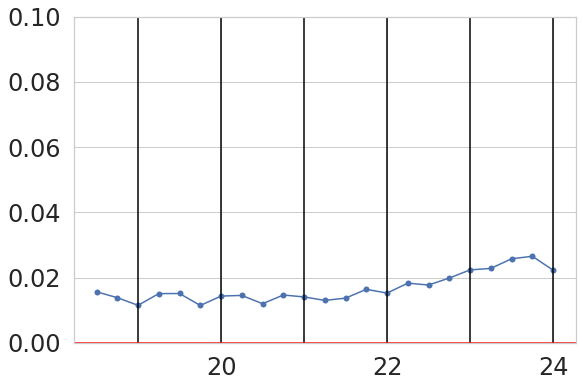

In [46]:
plt.plot(bmean, gal_cont_2, 'o-')
plt.ylim(0, .1)
plt.axhline(0.9, c='k')
for i in np.arange(19, 25, 1):
    plt.axvline(i, c='k')
for i in np.arange(0, 1, .1):
    plt.axhline(i, c='r')
plt.gcf().set_size_inches(9, 6)

In [11]:
print('all: ', len(sof[in_bin]))
print('true stars: ', len(np.where(true_stars_in_bin)[0]))
print('true gals: ',len(np.where(true_gals_in_bin)[0]))
print('meas stars: ',len(np.where(meas_stars_in_bin)[0]))
print('meas gals: ',len(np.where(meas_gals_in_bin)[0]))

all:  1983884
true stars:  137687
true gals:  1846197
meas stars:  177070
meas gals:  1806814


In [10]:
print('all: ', len(sof[in_bin]))
print('knn = 1', len(true_gals_in_bin))
print('knn = 2', len(true_stars_in_bin))

all:  1983884
knn = 1 7218607
knn = 2 7218607


(array([0.0000e+00, 3.0000e+00, 2.1000e+01, 9.0000e+01, 3.1200e+02,
        8.6300e+02, 1.3190e+03, 1.4866e+04, 9.7804e+04, 2.6954e+04,
        2.6100e+02]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 11 Patch objects>)

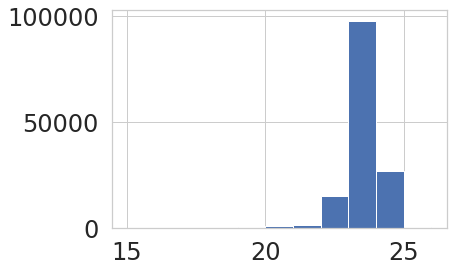

In [24]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 19
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bmin, bmax = 18, 26
db = 0.25
bins = np.arange(bmin, bmax, db)
Nbins = len(bins)

bindx = dict(zip('griz', range(4)))

# DF Sample
df_col = 'true_bdf_mag_deredden'
ecol = 'meas_EXTENDED_CLASS_SOF'

knn = 'NearestNeighbors_class'
knn_gals = 1
knn_stars = 2 

for band in 'i':
    print(f'Starting {band}')
    bi = bindx[band]
    
    # Efficiency
    star_eff_1 = np.zeros(Nbins)
    star_eff_2 = np.zeros(Nbins)
    star_eff_3 = np.zeros(Nbins)
    gal_eff_1 = np.zeros(Nbins)
    gal_eff_2 = np.zeros(Nbins)
    gal_eff_3 = np.zeros(Nbins)

    # Contamination
    star_con_1 = np.zeros(Nbins)
    star_con_2 = np.zeros(Nbins)
    star_con_3 = np.zeros(Nbins)
    gal_con_1 = np.zeros(Nbins)
    gal_con_2 = np.zeros(Nbins)
    gal_con_3 = np.zeros(Nbins)
    
    star_mag = stars[f'true_mag_{band}']
    sof_mag = sof['true_bdf_mag_deredden'][:, bi]

    k = 0
    for b1, b2 in zip(bins, bins+db):
        if b1 >= bmax:
            break 

    in_bin = (sof[df_col][:,bi] >= b1) & (sof[df_col][:,bi] < b2)

    true_stars_in_bin = in_bin & (sof[knn] == knn_stars)
    true_gals_in_bin = in_bin & (sof[knn] == knn_gals)

    thresh = 1

    meas_stars_in_bin = in_bin & (sof[ecol] >= 0) & (sof[ecol] <= thresh)
    meas_gals_in_bin  = in_bin & (sof[ecol] > thresh) & (sof[ecol] <= 3)

    # For Stellar selection:
    stars_true_positive = np.where(true_stars_in_bin & meas_stars_in_bin)[0]
    stars_false_positive = np.where(true_gals_in_bin & meas_stars_in_bin)[0]
    stars_false_negative = np.where(true_stars_in_bin & meas_gals_in_bin)[0]
    stars_true_negative = np.where(true_gals_in_bin & meas_gals_in_bin)[0]

    # For Galaxy selection:
    gals_true_positive = np.where(true_gals_in_bin & meas_gals_in_bin)[0]
    gals_false_positive = np.where(true_stars_in_bin & meas_gals_in_bin)[0]
    gals_false_negative = np.where(true_gals_in_bin & meas_stars_in_bin)[0]
    gals_true_negative = np.where(true_stars_in_bin & meas_stars_in_bin)[0]

    # Efficiency is True Positive Rate (TPR): TP / P = TP / (TP + FN)
    try:
        star_eff = len(stars_true_positive) / (len(stars_true_positive) + len(stars_false_negative))
        gal_eff  = len(gals_true_positive) / (len(gals_true_positive) + len(gals_false_negative))
    except ZeroDivisionError:
        star_eff_1[k] = 0
        star_eff_2[k] = 0
        star_eff_3[k] = 0
        gal_eff_1[k] = 0
        gal_eff_2[k] = 0
        gal_eff_3[k] = 0

    # Contamination is False Discovery Rate (FDR): FP / (FP + TP)
    try:
        star_cont = len(stars_false_positive) / (len(stars_false_positive) + len(stars_true_positive))
        gal_cont = len(gals_false_positive) / (len(gals_false_positive) + len(gals_true_positive))
    except ZeroDivisionError:
        star_cont_1[k] = 0
        star_cont_2[k] = 0
        star_cont_3[k] = 0
        gal_cont_1[k] = 0
        gal_cont_2[k] = 0
        gal_cont_3[k] = 0
    
# print('star_eff: ', star_eff)
# print('star_cont: ', star_cont)
# print('gal_eff: ', gal_eff)
# print('gal_cont: ', gal_cont)

(array([7.00000e+00, 9.50000e+01, 4.71000e+02, 6.21000e+02, 9.88000e+02,
        2.63700e+03, 7.09600e+03, 9.33650e+04, 9.64449e+05, 3.83637e+05,
        6.29900e+03]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 11 Patch objects>)

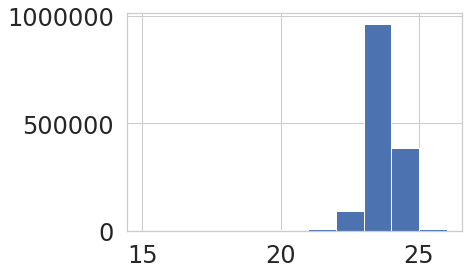

In [23]:
plt.hist(sof['true_bdf_mag_deredden'][:,2][sof[col] == 2], bins=np.arange(15, 27, 1))

(array([1073605.,       0.,       0.,  172830.,       0.,       0.,
         142516.,       0.,       0.,   91798.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

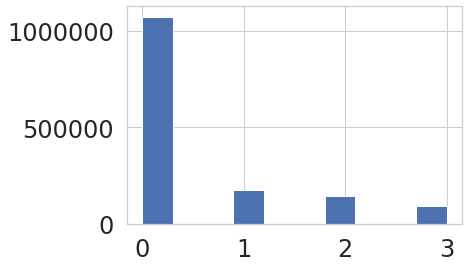

In [13]:
plt.hist(stars[col])

star_Nin_binx plot

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

NameError: name 'truncate_colormap' is not defined

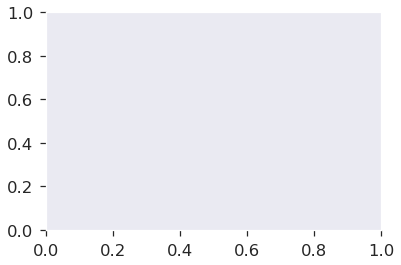

In [7]:
fig, ax = plt.subplots()
s = 12

band = 'i'
mmin, mmax = 18.5, 24.5
dm = 0.25
mbins = np.arange(mmin, mmax, dm)
Nmbins = len(mbins)

bi = dict(zip('griz', range(4)))[band]

col = 'meas_EXTENDED_CLASS_SOF'

knn = 'NearestNeighbors_class'
knn_val = 1

# Compute matrix
star_0 = np.zeros(Nmbins)
star_1 = np.zeros(Nmbins)
star_2 = np.zeros(Nmbins)
star_3 = np.zeros(Nmbins)

sof_0 = np.zeros(Nmbins)
sof_1 = np.zeros(Nmbins)
sof_2 = np.zeros(Nmbins)
sof_3 = np.zeros(Nmbins)

# Paper Table
# paper_t = np.zeros(5, Nmbins)

star_mag = stars[f'true_mag_{band}']
sof_mag = sof['true_bdf_mag_deredden'][:, bi]
    
k = 0
for b1, b2 in zip(mbins, mbins+dm):
#     print(b1, b2)
    if b1 >= mmax:
        break

    star_in_bin = (star_mag >= b1) & (star_mag < b2) 
    star_Nin_bin = len(np.where(star_in_bin == True)[0])

    star_ext0 = np.where(star_in_bin & (stars[col] == 0))
    star_ext1 = np.where(star_in_bin & (stars[col] == 1))
    star_ext2 = np.where(star_in_bin & (stars[col] == 2))
    star_ext3 = np.where(star_in_bin & (stars[col] == 3))

    sof_in_bin = (sof_mag >= b1) & (sof_mag < b2) & (sof[knn]==knn_val)
    sof_Nin_bin = len(np.where(sof_in_bin == True)[0])

    sof_ext0 = np.where(sof_in_bin & (sof[col] == 0))
    sof_ext1 = np.where(sof_in_bin & (sof[col] == 1))
    sof_ext2 = np.where(sof_in_bin & (sof[col] == 2))
    sof_ext3 = np.where(sof_in_bin & (sof[col] == 3))

    try:
        star_0[k] = 1. * len(star_ext0[0]) / star_Nin_bin
        star_1[k] = 1. * len(star_ext1[0]) / star_Nin_bin
        star_2[k] = 1. * len(star_ext2[0]) / star_Nin_bin
        star_3[k] = 1. * len(star_ext3[0]) / star_Nin_bin
    except ZeroDivisionError:
        star_0[k] = 0
        star_1[k] = 0
        star_2[k] = 0
        star_3[k] = 0

    try:
        sof_0[k] = 1. * len(sof_ext0[0]) / sof_Nin_bin
        sof_1[k] = 1. * len(sof_ext1[0]) / sof_Nin_bin
        sof_2[k] = 1. * len(sof_ext2[0]) / sof_Nin_bin
        sof_3[k] = 1. * len(sof_ext3[0]) / sof_Nin_bin
    except ZeroDivisionError:
        sof_0[k] = 0
        sof_1[k] = 0
        sof_2[k] = 0
        sof_3[k] = 0

    k += 1
    
# Compute transfer matrix
bmin, bmax = mmin, mmax
db = dm / 2.
bins = np.arange(bmin, bmax, db)
Nbins = len(bins)
matrix = np.zeros((2, Nbins))

for i in range(Nbins):
    if i % 2 == 0:
        # Star -> Star
        matrix[0, i] = star_0[i // 2] + star_1[i // 2]
        # Star -> Galaxy
        matrix[1, i] = star_3[i // 2] + star_2[i // 2]
    else:
        # Galaxy - > Star
        matrix[0, i] = sof_0[(i-1) // 2] + sof_1[(i-1) // 2]
        # Galaxy -> Galaxy
        matrix[1, i] = sof_3[(i-1) // 2] + sof_2[(i-1) // 2]
        
# Compute paper table
paper_t = Table()

# star_0 + star[1]

paper_t['Mag'] = mbins
paper_t['Star->Star'] = np.round(100 * matrix[0,::2], 1)
paper_t['Gal->Star'] = np.round(100 * matrix[0,1::2], 1)
paper_t['Star->Gal'] = np.round(100 * matrix[1,::2], 1)
paper_t['Gal->Gal'] = np.round(100 * matrix[1, 1::2], 1)

paper_t.write('./tables/balrog-confusion-matrix.csv')
        
plt.rcParams["axes.grid"] = False
ax.matshow(matrix, cmap=truncate_colormap(plt.cm.Blues, maxval=0.7, minval = 0.1), origin='lower-left')
ax.xaxis.set_ticks_position('bottom')
        
for i in range(Nbins):
    if i % 2 == 0:
        plt.axvline(i-0.5, lw=2, c='k')
    for j in range(2):
        c = int(np.round(100*matrix[j, i]))
        if c > 0:
            ax.text(i, j, str(c), va='center', ha='center')
            
plt.axvline(-0.435, lw=2, c='k')
plt.axvline(Nbins-0.52, lw=2, c='k')
        
plt.xlabel(f'True {band}-mag')
plt.xticks(ticks=np.arange(Nbins)[::2]+0.5, labels=mbins)
plt.yticks(ticks=[0, 1], labels=['Meas Star', 'Meas Galaxy'])
# plt.ylabel(f'True {band}-mag')
plt.gcf().set_size_inches(20, 4)

In [5]:
pwd

'/global/u2/s/severett/balrog-paper-plots'

In [48]:
(100*np.round(matrix[1, 1::2], 2)).astype(int)

array([93, 96, 96, 96, 94, 96, 98, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98,
       98, 98, 98, 98, 97, 96, 95, 93, 92, 90, 88, 86, 85, 86, 88])

In [44]:
matrix[0,1:-1:2]

array([0.06692407, 0.04492363, 0.04162855, 0.04253545, 0.05911164,
       0.03825232, 0.01593919, 0.02886475, 0.02866624, 0.02570522,
       0.02760349, 0.02325031, 0.01920322, 0.01772351, 0.0181897 ,
       0.01923907, 0.01827293, 0.01676358, 0.02154543, 0.01989691,
       0.02349889, 0.03157629, 0.04134053, 0.05190919, 0.06660782,
       0.08327684, 0.10104004, 0.12361588, 0.14483847, 0.15046963,
       0.14031213])

g, 0 of 4
Nmax = 5802233


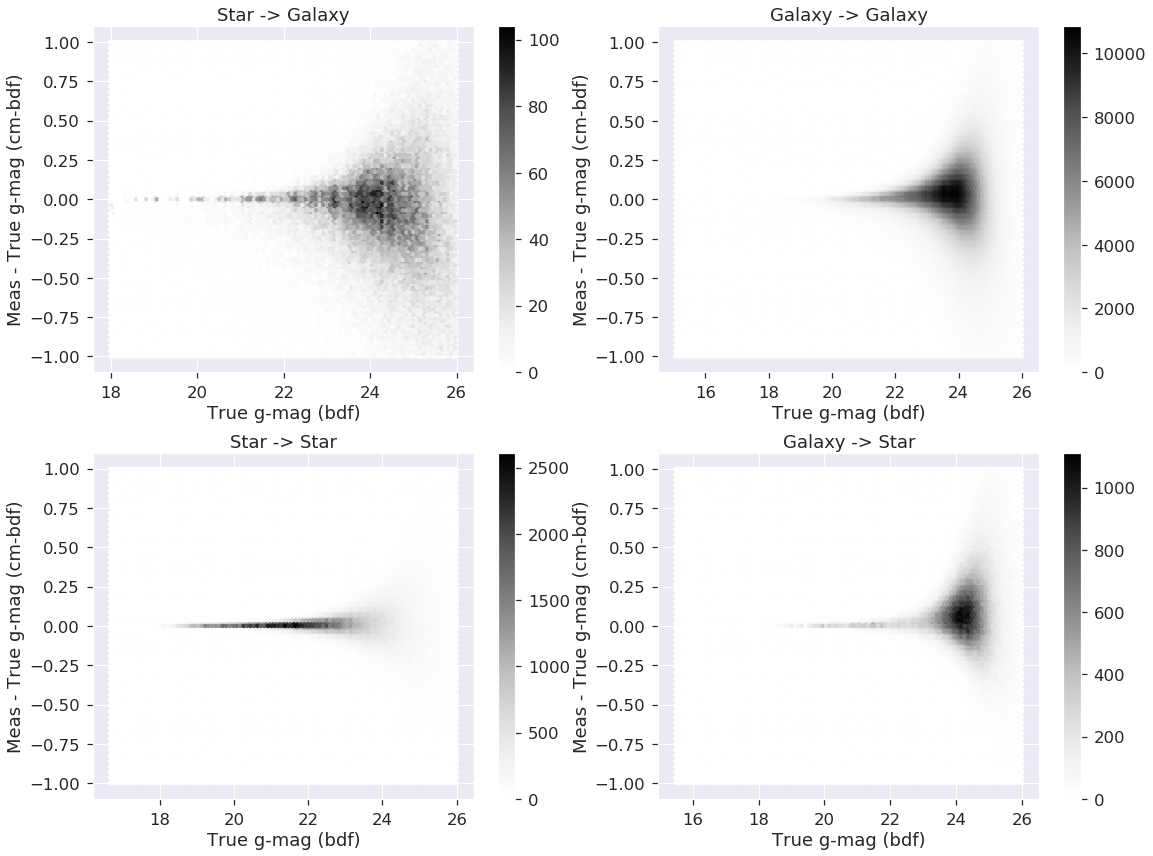

r, 1 of 4
Nmax = 6059168


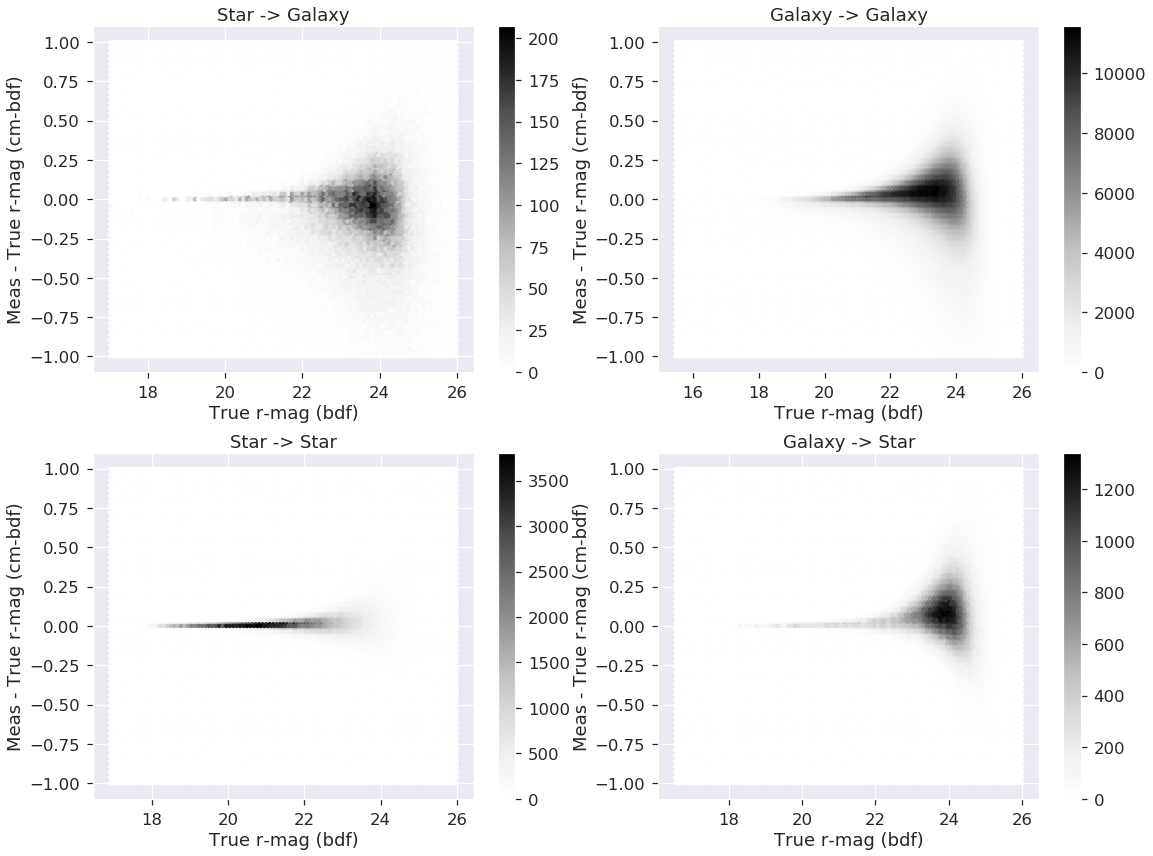

i, 2 of 4
Nmax = 6064193


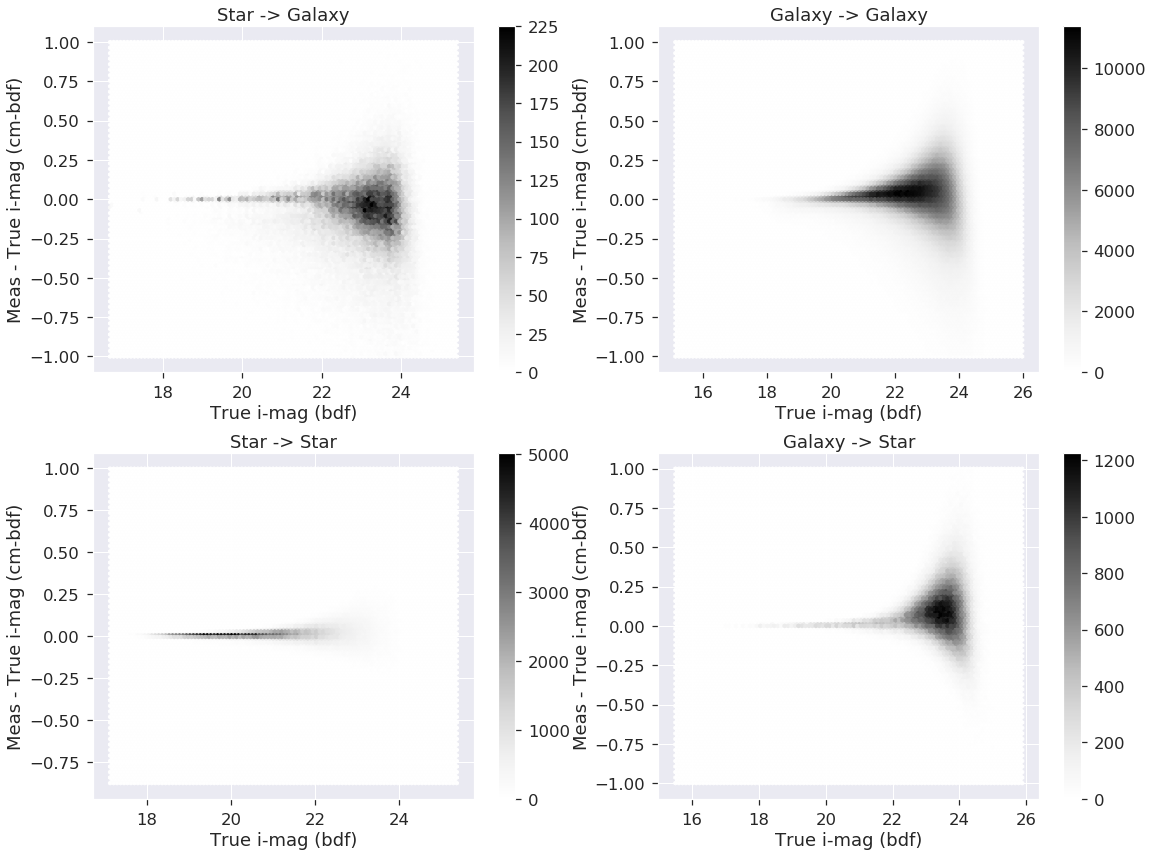

z, 3 of 4
Nmax = 5991523


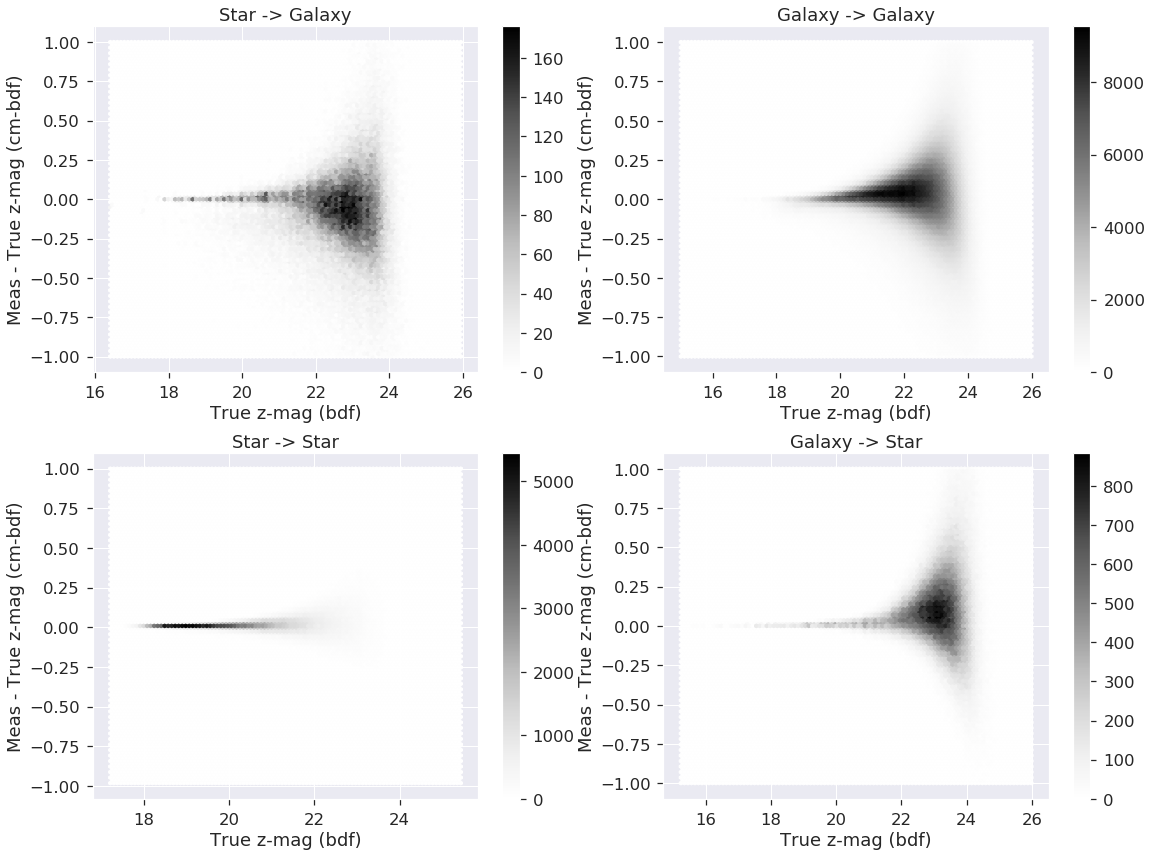

In [39]:
ext_col = 'meas_EXTENDED_CLASS_SOF'

knn_col = 'NearestNeighbors_class'
knn_gal = 1
knn_star = 2

# Make a single classifier col with same values as knn_class
sof['meas_class'] = np.zeros(len(sof))
sof['meas_class'][np.where(sof[ext_col] >= 2)] = 1 # galaxy
sof['meas_class'][np.where(sof[ext_col] <= 1)] = 2 # star
assert len(sof[sof['meas_class'] == 0]) == 0

xlim = [15, 26]
ylim = [-1, 1]

bands = 'griz'
bindx = dict(zip(bands, range(4)))
for b, bi in bindx.items():
    print(f'{b}, {bi} of {len(bands)}')
    
    
    true_mag = sof['true_bdf_mag_deredden'][:, bi]
    meas_mag = sof['meas_cm_mag_deredden'][:, bi]
    true_class = sof[knn_col]
    meas_class = sof['meas_class']
    
    x = true_mag
    y = meas_mag - x

    cuts = ( (x > xlim[0]) &
             (x < xlim[1]) &
             (y > ylim[0]) &
             (y < ylim[1])  )
    
    star2star = np.where((true_class == 2) & (meas_class == 2) & cuts)
    star2gal  = np.where((true_class == 2) & (meas_class == 1) & cuts)
    gal2star  = np.where((true_class == 1) & (meas_class == 2) & cuts)
    gal2gal   = np.where((true_class == 1) & (meas_class == 1) & cuts)
    
    fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0)
#     fig.subplots_adjust(0,0,1,1,0,0)
    
    Nmax = max([len(star2star[0]), len(star2gal[0]), len(gal2star[0]), len(gal2gal[0])])
    print(f'Nmax = {Nmax}')
    vmin, vmax = 0, Nmax
    
    
    
    plt.subplot(2, 2, 3)
    plt.hexbin(x[star2star], y[star2star], gridsize=100)#, vmin=0, vmax=Nmax)#, norm=colors.LogNorm(vmax=vm))
    plt.xlabel(f'True {b}-mag (bdf)')
    plt.ylabel(f'Meas - True {b}-mag (cm-bdf)')
    plt.title('Star -> Star')
    plt.colorbar()
    
    plt.subplot(2, 2, 1)
#     vm = 1. * len(star2gal) / Nmax
    plt.hexbin(x[star2gal], y[star2gal], gridsize=100)#, norm=colors.LogNorm(vmax=vm))
    plt.xlabel(f'True {b}-mag (bdf)')
    plt.ylabel(f'Meas - True {b}-mag (cm-bdf)')
    plt.title('Star -> Galaxy')
    plt.colorbar()
    
    plt.subplot(2, 2, 4)
#     vm = 1. * len(gal2star) / Nmax
    plt.hexbin(x[gal2star], y[gal2star], gridsize=100)#, norm=colors.LogNorm(vmax=vm))
    plt.xlabel(f'True {b}-mag (bdf)')
    plt.ylabel(f'Meas - True {b}-mag (cm-bdf)')
    plt.title('Galaxy -> Star')
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
#     vm = 1. * len(gal2gal) / Nmax
    plt.hexbin(x[gal2gal], y[gal2gal], gridsize=100)#, norm=colors.LogNorm(vmax=vm))
    plt.xlabel(f'True {b}-mag (bdf)')
    plt.ylabel(f'Meas - True {b}-mag (cm-bdf)')
    plt.title('Galaxy -> Galaxy')
    plt.colorbar()
    
    plt.grid()
    fig.set_size_inches(16, 12)
    plt.tight_layout()
    plt.show()

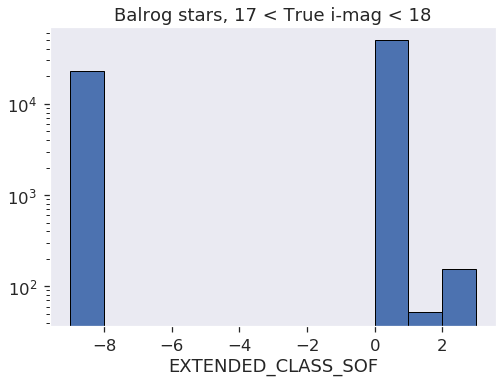

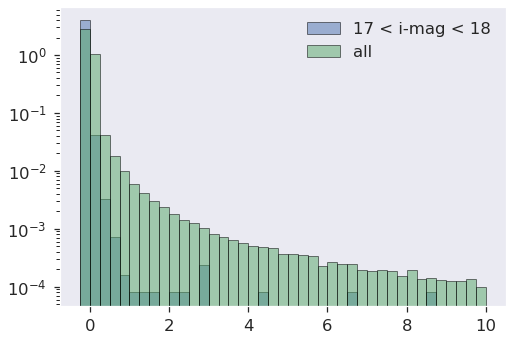

In [311]:
b1, b2 = 17, 18
star_in_bin = (star_mag >= b1) & (star_mag < b2)
star_Nin_bin = len(np.where(star_in_bin == True)[0])
plt.hist(stars[star_in_bin][col], ec='k', bins=np.arange(-9, 4, 1))
plt.xlabel('EXTENDED_CLASS_SOF')
plt.yscale('log')
plt.title('Balrog stars, 17 < True i-mag < 18')
plt.show()

dt = 0.25
bins = np.arange(-dt, 10+dt, dt)
plt.hist(stars[star_in_bin]['meas_cm_T'], ec='k', density=True, bins=bins, alpha=0.5, label='17 < i-mag < 18')
plt.hist(stars['meas_cm_T'],  ec='k', density=True, bins=bins, alpha=0.5, label='all')
plt.legend()
plt.yscale('log')

In [321]:
stars[stars[col]==-9]

true_g_Corr,true_gr_Corr,true_ri_Corr,true_iz_Corr,bal_id,meas_gapflux [4],meas_cm_T,meas_cm_s2n_r,meas_cm_fracdev,meas_cm_mag_deredden [4],meas_FLAGS_GOLD_SOF_ONLY,meas_EXTENDED_CLASS_SOF,flags_footprint,flags_foreground,flags_badregions,match_flag_1.5_asec,true_mag_g,true_mag_r,true_mag_i,true_mag_z
float64,float64,float64,float64,int64,float64,float64,float64,float32,float64,int32,int64,float64,float64,float64,int32,float64,float64,float64,float64
18.9999277255,0.989314282722,0.30978775167800005,0.145093777769,100002000412,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.111100003123 .. -9999.041700001806,2,-9,1.0,0.0,0.0,0,18.9999277255,18.010613442778002,17.7008256911,17.555731913331
17.3096703499,0.428972037074,0.135612876637,0.029822955207,100003044570,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.040100000799 .. -9999.015100000426,2,-9,1.0,0.0,0.0,0,17.3096703499,16.880698312826,16.745085436188997,16.715262480982
19.0339799453,1.3571955825600002,0.7129332274439999,0.343275460051,100003044574,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.040100000799 .. -9999.015100000426,2,-9,1.0,0.0,0.0,0,19.0339799453,17.67678436274,16.963851135296,16.620575675245
19.9585442735,1.3643793080000002,0.867928136842,0.371398286655,100004036234,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.03599999845 .. -9999.01350000035,2,-9,1.0,0.0,0.0,0,19.9585442735,18.5941649655,17.726236828658,17.354838542002998
17.9560842834,0.371332279961,0.0850986710003,0.0030582408085000003,100014042497,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.028300000355 .. -9999.010599999689,2,-9,1.0,0.0,0.0,0,17.9560842834,17.584752003439,17.4996533324387,17.4965950916302
17.4208968972,0.7733297234550001,0.202287855444,0.109950933748,100015050404,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.047400001436 .. -9999.017799999565,2,-9,1.0,0.0,0.0,0,17.4208968972,16.647567173745,16.445279318301,16.335328384553
17.208778229900002,0.594379807087,0.128669668338,0.0472724991928,100015058319,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.03599999845 .. -9999.01350000035,2,-9,1.0,0.0,0.0,0,17.208778229900002,16.614398422813,16.485728754475,16.4384562552822
19.4432748028,1.4042628854,0.810173487066,0.370627499448,100018049148,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.048999998719 .. -9999.018400000408,2,-9,1.0,0.0,0.0,0,19.4432748028,18.0390119174,17.228838430334,16.858210930886003
17.0676277211,0.173023795779,0.013799056276,-0.0196736687065,100022034159,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.03790000081 .. -9999.014200000092,2,-9,1.0,0.0,0.0,0,17.0676277211,16.894603925321,16.880804869045,16.9004785377515


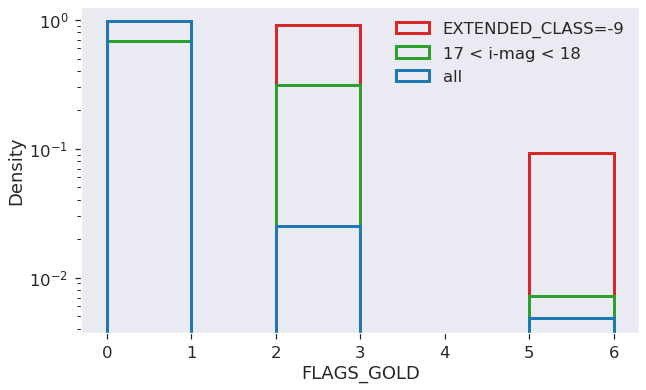

In [329]:
bins = np.arange(0, 7, 1)
plt.hist(stars[stars[col]==-9]['meas_FLAGS_GOLD_SOF_ONLY'], label='EXTENDED_CLASS=-9', histtype='step', lw=3, density=True, bins=bins, color='tab:red')
plt.hist(stars[star_in_bin]['meas_FLAGS_GOLD_SOF_ONLY'], label='17 < i-mag < 18', histtype='step', lw=3, density=True, bins=bins, color='tab:green')
plt.hist(stars['meas_FLAGS_GOLD_SOF_ONLY'], label='all', histtype='step', lw=3, density=True, bins=bins, color='tab:blue')
plt.legend()
plt.yscale('log')
plt.xlabel('FLAGS_GOLD')
plt.ylabel('Density')
plt.gcf().set_size_inches(10, 6)

In [52]:
len(sof[sof[knn] == 1])

5608710

In [127]:
run = 'run2'
ver = '1.0'
fname = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/stars/{}/sof/balrog_matched_catalog_sof_{}_stars_v{}.fits'.format(run, ver, run, ver)

# from astropy.io import fits
# with fits.open(fname) as f:
#     print(f[1].columns)
    
cols = ['meas_psf_flux', 'meas_psf_mag', 'meas_cm_mag', 'true_g_Corr', 'true_gr_Corr', 'true_ri_Corr', 'true_iz_Corr', 'meas_gapflux', 'meas_cm_flux']
for b in 'griz':
    cols.append(f'true_PSF_FLUX_{b}')
    cols.append(f'true_PSF_MAG_{b}')
t = Table(fitsio.read(fname, columns=cols))

t['true_mag_g'] = t['true_g_Corr']
t['true_mag_r'] = t['true_g_Corr'] - t['true_gr_Corr']
t['true_mag_i'] = t['true_g_Corr'] - t['true_gr_Corr'] - t['true_ri_Corr']
t['true_mag_z'] = t['true_g_Corr'] - t['true_gr_Corr'] - t['true_ri_Corr'] - t['true_iz_Corr']

for b in 'griz':
    t[f'true_flux_{b}'] = np.power(10., -(t[f'true_mag_{b}']-30)/2.5)

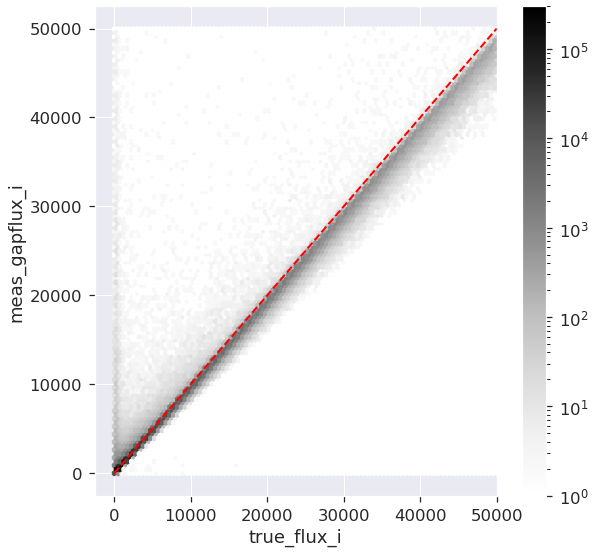

In [128]:
bindx = dict(zip('griz', range(4)))
xlim = [0, 5e4]
ylim = xlim

b = 'i'
bi = bindx[b]
x = t[f'true_flux_{b}']
y = t['meas_cm_flux'][:, bi]
cuts = np.where((x > xlim[0]) & (x < xlim[1]) &
                (y > ylim[0]) & (y < ylim[1]))
plt.hexbin(x[cuts], y[cuts], norm=colors.LogNorm())
plt.colorbar()
plt.plot(xlim, ylim, c='r', ls='--', lw=2)
plt.xlabel(f'true_flux_{b}')
plt.ylabel(f'meas_gapflux_{b}')
# plt.xscale('log')
# plt.yscale('log')
plt.gcf().set_size_inches(9, 9)
plt.show()

In [139]:
dfile = '/project/projectdirs/des/severett/Balrog/run2/stacked_catalogs/stars/1.4/sof/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'

f = Table(fitsio.read(dfile))

(array([2361887.,       0.,       0.,       0.,       0.,   54073.,
              0.,       0.,       0.,   46553.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

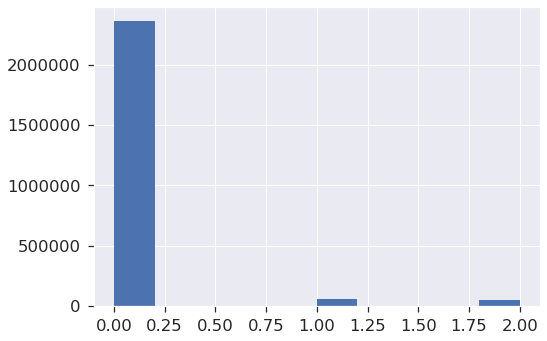

In [141]:
plt.hist(f['match_flag_1.5_asec'])

In [143]:
print(100.*len(f[f['match_flag_1.5_asec'] == 0]) / len(f))
print(100.*len(f[f['match_flag_1.5_asec'] == 1]) / len(f))
print(100.*len(f[f['match_flag_1.5_asec'] == 2]) / len(f))

95.91368654703548
2.195846275735397
1.890467177229115
